Original Researcher: **Omer Raza Khan** and **Kevin Qu** 

The research done to create this model can be found [here](https://github.com/afnanrahman/EAFP/blob/main/notebooks/support_vector_classifier.ipynb)

###SVM Results Summary

The SVM base model had the accuracy of 48.6%

*   Standard Scaled Features + Linear Kernel: ~92.2%
*   Foward Sequential Feature Selector: ~92.4%

Hyperparameter Tuning on the feature selected model 
*  Grid Search: 92%

### Imports and Data

In [22]:
# Standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Preprocessing
from sklearn.preprocessing import StandardScaler

#Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# Model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 

#Model Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

#Model Selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Clustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

import pickle
import time

import warnings
warnings.filterwarnings("ignore")

In [11]:
data_df = pd.read_csv("https://raw.githubusercontent.com/afnanrahman/EAFP/main/data/one_hot_encoded_smote_data.csv")

In [12]:
data_df= data_df.drop(columns = ['monthly_rate', 'hourly_rate', 'daily_rate'], axis = 1)
x = data_df.drop(columns = ['attrition'], axis = 1)
y = data_df['attrition']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## SVM Model Training

### Base model Accuracy = 48.6%

In [13]:
clf = SVC(kernel='rbf')
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.4864864864864865

### Scaled Features + Linear Kernel: Accuracy = 92.2%

In [14]:
# Manually removing similar columns (in terms of context)
remove = ['total_working_years', 'years_at_company', 'percent_salary_hike',
               'years_with_curr_manager']
no_attrition = data_df.drop('attrition', axis=1)
no_correlation = [e for e in list(no_attrition.columns) if e not in remove]
no_correlation

['age',
 'distance_from_home',
 'education',
 'employee_number',
 'environment_satisfaction',
 'job_involvement',
 'job_level',
 'job_satisfaction',
 'num_companies_worked',
 'performance_rating',
 'relationship_satisfaction',
 'stock_option_level',
 'training_times_last_year',
 'work_life_balance',
 'years_in_current_role',
 'business_travel_non-_travel',
 'business_travel_travel_frequently',
 'business_travel_travel_rarely',
 'department_human_resources',
 'department_research_&_development',
 'department_sales',
 'education_field_human_resources',
 'education_field_life_sciences',
 'education_field_marketing',
 'education_field_medical',
 'education_field_other',
 'education_field_technical_degree',
 'gender_female',
 'gender_male',
 'job_role_healthcare_representative',
 'job_role_human_resources',
 'job_role_laboratory_technician',
 'job_role_manager',
 'job_role_manufacturing_director',
 'job_role_research_director',
 'job_role_research_scientist',
 'job_role_sales_executive',
 '

In [15]:
sc = StandardScaler()
sc.fit(data_df[no_correlation])
data_scale = sc.transform(data_df[no_correlation])

In [16]:
X = data_scale
Y = data_df['attrition']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, Y_train)
clf_linear.score(X_test, Y_test)

0.9216216216216216

### Forward Selection Accuracy = 92.4%

In [19]:
# Training on multiple number of columns, storing accuracy in scores{}
scores = {}
for n in range(1,44,10):
  clf_sfs = SVC(kernel='linear')
  sfs = SequentialFeatureSelector(clf_sfs, n_features_to_select=n, direction="forward", scoring='accuracy')
  sfs = sfs.fit(X_train, Y_train)
  feat_cols = sfs.get_support(indices=True)
  clf_sfs.fit(X_train[:, feat_cols], Y_train)
  y_test_pred = clf_sfs.predict(X_test[:, feat_cols])
  scores[n] = accuracy_score(Y_test, y_test_pred)

In [20]:
# Printing accuracies by {number of cols : accuracy} pairs
for key, value in scores.items():
    print(key, ' : ', value)

1  :  0.745945945945946
11  :  0.8324324324324325
21  :  0.8837837837837837
31  :  0.9108108108108108
41  :  0.9243243243243243


###GridSearchCV Accuracy = 92%

In [23]:
# Defining parameter grid and intializing GridSearch
param_grid = {"C": [0.01, 0.1, 1, 10, 100],
              "gamma": [0.01, 0.1, 1, 10, 100]}
grid_cv = GridSearchCV(SVC(kernel='linear'), param_grid, verbose=0)
grid_cv.fit(X_train, Y_train)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]})

In [24]:
print(grid_cv.best_estimator_)

SVC(C=10, gamma=0.01, kernel='linear')


              precision    recall  f1-score   support

           0       0.88      0.97      0.93       369
           1       0.97      0.87      0.92       371

    accuracy                           0.92       740
   macro avg       0.93      0.92      0.92       740
weighted avg       0.93      0.92      0.92       740



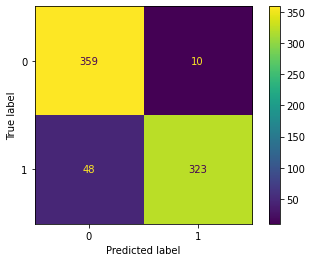

In [25]:
grid_pred = grid_cv.predict(X_test)
cm = confusion_matrix(Y_test, grid_pred, labels=grid_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_cv.classes_)
disp.plot()

print(classification_report(Y_test, grid_pred))

Setting **C = 10** and **gamma = 0.01** gives us the best Support Vector Classifier of attrition, with an **accuracy of 92%**, using *GridSearchCV*

In [ ]:
all_preds = clf_linear.predict(data_scale)
preds = pd.DataFrame({"predict_attrition":all_preds})
preds.value_counts()

predict_attrition
0                    1343
1                    1123
dtype: int64

In [ ]:
only_attr = preds[preds["predict_attrition"] == 1]
only_attr.value_counts()

predict_attrition
1                    1123
dtype: int64

In [ ]:
data_cp = data_df.copy()
predict_attrition = pd.concat([data_cp, only_attr], axis=1) 
predict_attrition = predict_attrition[predict_attrition["predict_attrition"] == 1]
predict_attrition.head()

,age,distance_from_home,education,employee_number,environment_satisfaction,job_involvement,job_level,job_satisfaction,num_companies_worked,percent_salary_hike,...,job_role_sales_executive,job_role_sales_representative,marital_status_divorced,marital_status_married,marital_status_single,over_time_no,over_time_yes,attrition,rate_avg,predict_attrition
0,41,1,2,1,2,3,2,4,8,11,...,1,0,0,0,1,0,1,1,6891.67,1.0
2,37,2,2,4,4,2,1,3,6,15,...,0,0,0,0,1,0,1,1,1287.00,1.0
14,28,24,3,19,3,2,1,3,5,14,...,0,0,0,0,1,0,1,1,4366.67,1.0
21,36,9,4,27,3,2,1,1,7,23,...,0,1,0,0,1,1,0,1,2762.00,1.0
26,32,16,1,33,2,1,1,1,1,22,...,0,0,0,0,1,0,1,1,1959.33,1.0


##Pickle file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/models'
filename = 'final_svm_model.sav'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pickle the model
import pickle
import os
pickle_out = open(os.path.join(path, filename), "wb")
pickle.dump(clf_linear, pickle_out)
pickle_out.close()

In [ ]:
# load the model from drive 
path_to_embed = os.path.join(path, filename)
loaded_model = pickle.load(open(path_to_embed, "rb"))

all_preds = loaded_model.predict(X)
pred_attr = pd.DataFrame({'predict_attrition': all_preds})

## Clustering

In [ ]:
a = pd.DataFrame(X, columns=no_correlation)
pred_attr = pd.concat([a, predict_attrition], axis=1)
no_attr = pred_attr[pred_attr['predict_attrition'] == 1]


iclustering_data= no_attr.drop("predict_attrition", axis = 1)
iclustering_data.columns.sort_values()

Index(['age', 'age', 'attrition', 'business_travel_non-_travel',
       'business_travel_non-_travel', 'business_travel_travel_frequently',
       'business_travel_travel_frequently', 'business_travel_travel_rarely',
       'business_travel_travel_rarely', 'department_human_resources',
       'department_human_resources', 'department_research_&_development',
       'department_research_&_development', 'department_sales',
       'department_sales', 'distance_from_home', 'distance_from_home',
       'education', 'education', 'education_field_human_resources',
       'education_field_human_resources', 'education_field_life_sciences',
       'education_field_life_sciences', 'education_field_marketing',
       'education_field_marketing', 'education_field_medical',
       'education_field_medical', 'education_field_other',
       'education_field_other', 'education_field_technical_degree',
       'education_field_technical_degree', 'employee_number',
       'employee_number', 'environment_s

#### K means, k=3

In [ ]:
clustering_kmeans3 = KMeans(init='k-means++', n_clusters=3, random_state=42)
clusters_kmeans3 = clustering_kmeans3.fit_predict(iclustering_data)

### TSNE for visualization

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state= 42,perplexity= 50, n_iter=4000)
kmeans_tsne_comps = tsne.fit_transform(iclustering_data)

In [ ]:
kmeans_tsne_comps_df = pd.DataFrame(data=kmeans_tsne_comps, columns=['TSNE_1', 'TSNE_2'])
kmeans_tsne_comps_df['cluster'] = clusters_kmeans3
kmeans_tsne_comps_df 

,TSNE_1,TSNE_2,cluster
0,2.278102,20.280901,2
1,-35.500256,-15.396199,1
2,6.771389,-20.596598,0
3,-1.400880,-30.764608,1
4,-32.290489,-16.694979,1
...,...,...,...
1118,-24.750753,-6.402444,1
1119,-29.212654,-16.332359,1
1120,19.667616,2.391416,0
1121,-27.439051,-16.500256,1


Text(0, 0.5, 'TSNE_2')

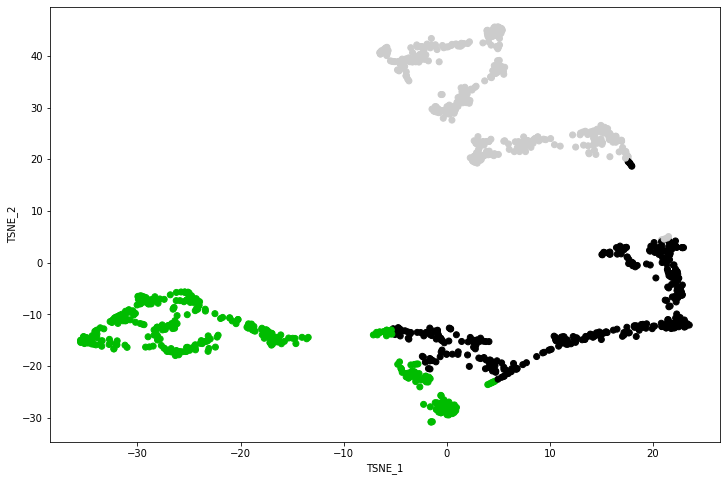

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(kmeans_tsne_comps_df['TSNE_1'],kmeans_tsne_comps_df['TSNE_2'],c=kmeans_tsne_comps_df['cluster'], cmap='nipy_spectral')

plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')

### Clustering Metric: Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(iclustering_data, clustering_kmeans3.labels_, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score)


Silhouetter Score: 0.596


### Cluster Interpretations: Visualizations

In [ ]:
predict_attrition = predict_attrition.set_index(np.arange(1121))
predict_attrition["cluster"] = clusters_kmeans3
predict_attrition


,age,distance_from_home,education,environment_satisfaction,job_involvement,job_level,job_satisfaction,num_companies_worked,percent_salary_hike,performance_rating,...,job_role_sales_representative,marital_status_divorced,marital_status_married,marital_status_single,over_time_no,over_time_yes,attrition,rate_avg,predict_attrition,cluster
0,41,1,2,2,3,2,4,8,11,3,...,0,0,0,1,0,1,1,6891.67,1.0,2
1,37,2,2,4,2,1,3,6,15,3,...,0,0,0,1,0,1,1,1287.00,1.0,0
2,28,24,3,3,2,1,3,5,14,3,...,0,0,0,1,0,1,1,4366.67,1.0,1
3,36,9,4,3,2,1,1,7,23,4,...,1,0,0,1,1,0,1,2762.00,1.0,0
4,32,16,1,2,1,1,1,1,22,4,...,0,0,0,1,0,1,1,1959.33,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,35,7,1,2,3,1,2,3,12,3,...,0,0,0,0,1,0,1,1524.67,1.0,0
1117,33,18,2,1,3,1,3,6,14,3,...,0,0,0,1,0,1,1,2014.33,1.0,0
1118,31,25,4,1,2,1,3,1,22,3,...,0,0,0,0,0,0,1,6180.00,1.0,1
1119,41,23,2,2,2,2,2,2,12,3,...,0,0,1,0,0,0,1,2166.67,1.0,0


In [ ]:
predict_attrition.columns

Index(['age', 'distance_from_home', 'education', 'environment_satisfaction',
       'job_involvement', 'job_level', 'job_satisfaction',
       'num_companies_worked', 'percent_salary_hike', 'performance_rating',
       'relationship_satisfaction', 'stock_option_level',
       'total_working_years', 'training_times_last_year', 'work_life_balance',
       'years_at_company', 'years_in_current_role', 'years_with_curr_manager',
       'business_travel_non-_travel', 'business_travel_travel_frequently',
       'business_travel_travel_rarely', 'department_human_resources',
       'department_research_&_development', 'department_sales',
       'education_field_human_resources', 'education_field_life_sciences',
       'education_field_marketing', 'education_field_medical',
       'education_field_other', 'education_field_technical_degree',
       'gender_female', 'gender_male', 'job_role_healthcare_representative',
       'job_role_human_resources', 'job_role_laboratory_technician',
       'job

In [ ]:
numeric = ["rate_avg", "distance_from_home",  "age", "years_in_current_role", "total_working_years", "years_at_company", "percent_salary_hike",
            "years_with_curr_manager", "attrition", "predict_attrition"]

# add the exploded variables 
exploded_variables = ['business_travel_non-_travel', 'business_travel_travel_frequently','business_travel_travel_rarely', 'department_human_resources',
       'department_research_&_development', 'department_sales', 'education_field_human_resources', 'education_field_life_sciences', 'education_field_marketing', 'education_field_medical',
       'education_field_other', 'education_field_technical_degree','gender_female', 'gender_male', 'job_role_healthcare_representative','job_role_human_resources', 'job_role_laboratory_technician',
       'job_role_manager', 'job_role_manufacturing_director', 'job_role_research_director', 'job_role_research_scientist','job_role_sales_executive', 'job_role_sales_representative',
       'marital_status_divorced', 'marital_status_married','marital_status_single', 'over_time_no', 'over_time_yes']

#### Categorical Variables 

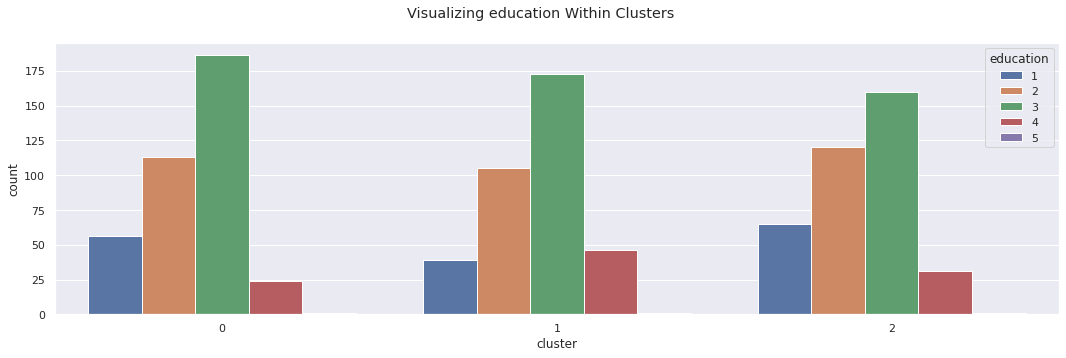

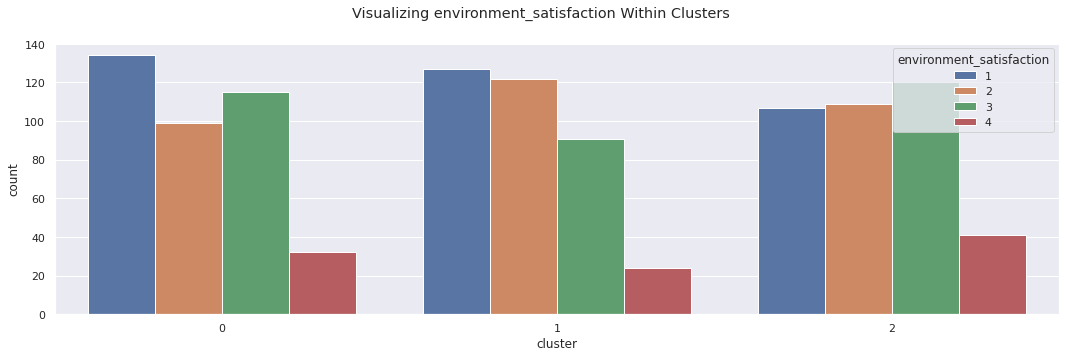

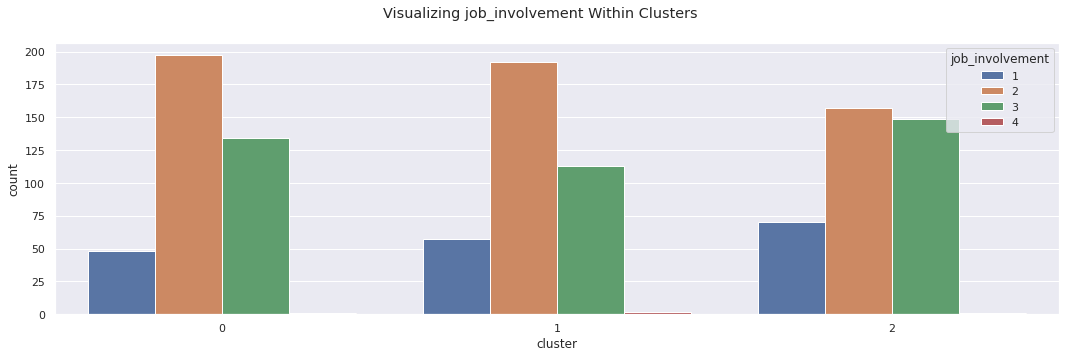

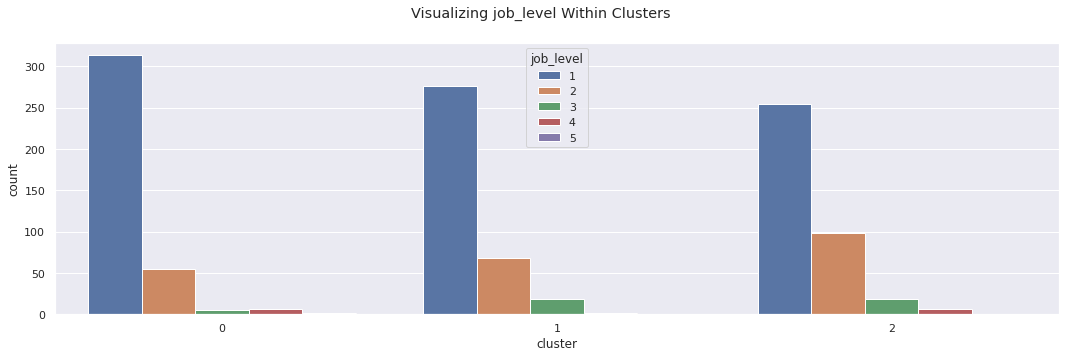

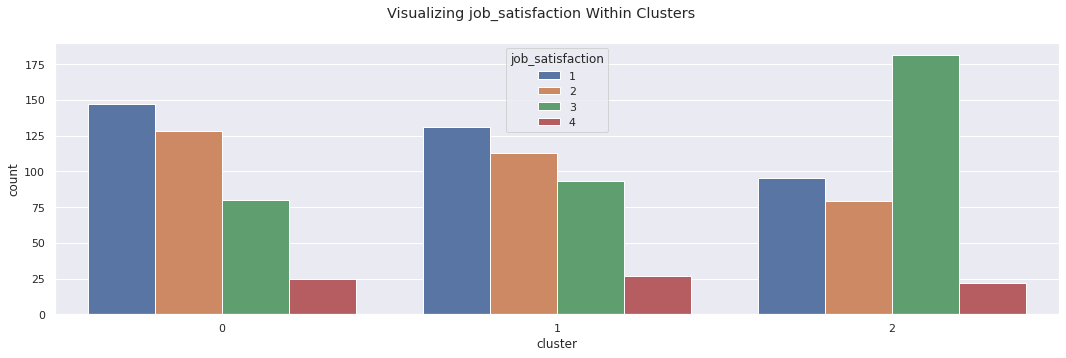

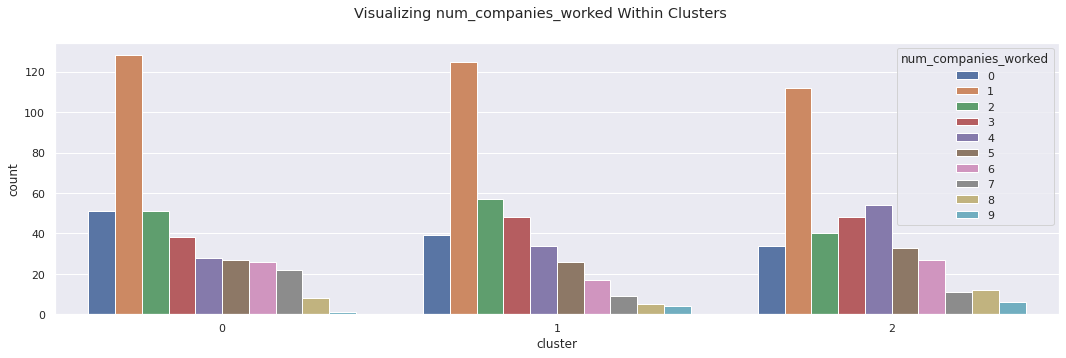

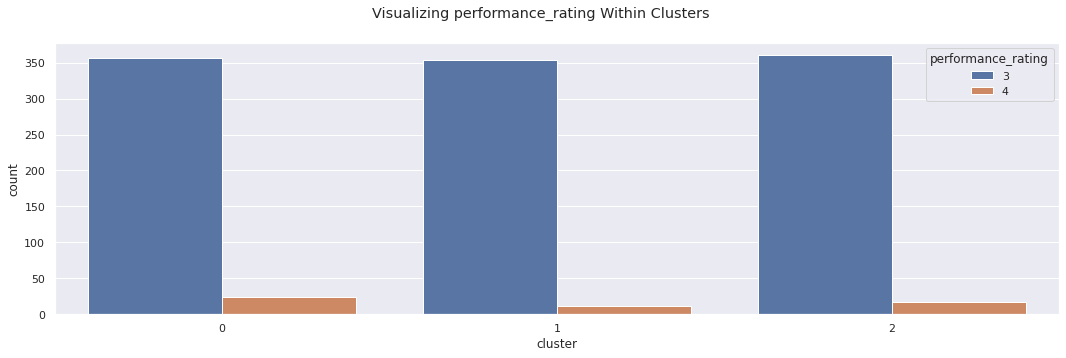

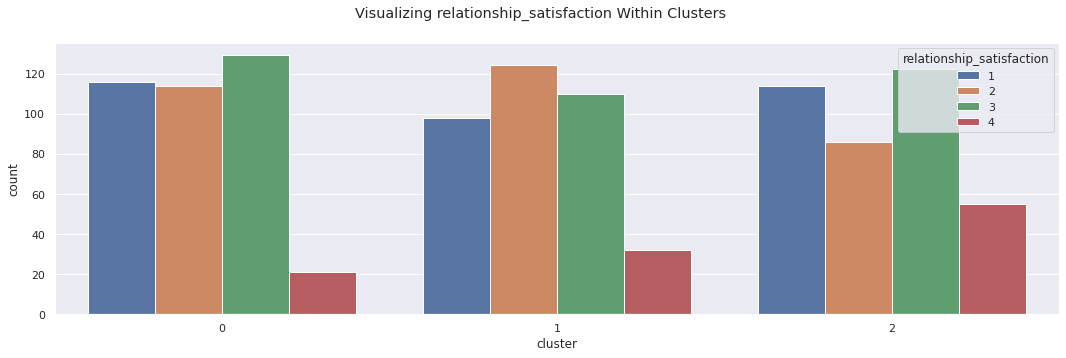

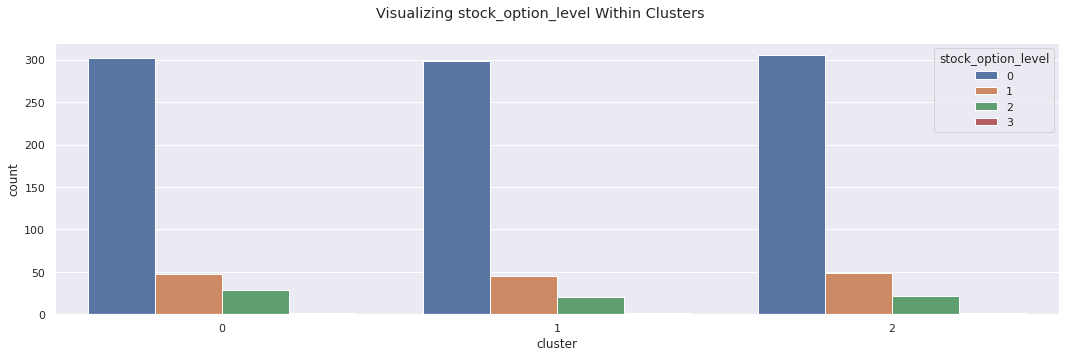

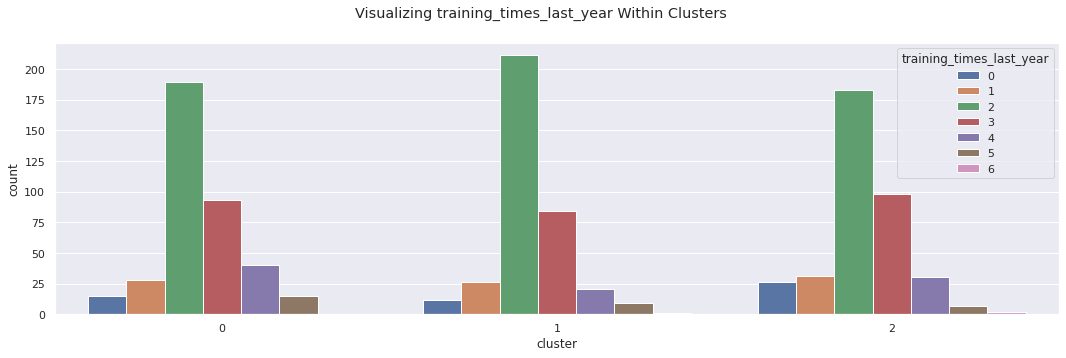

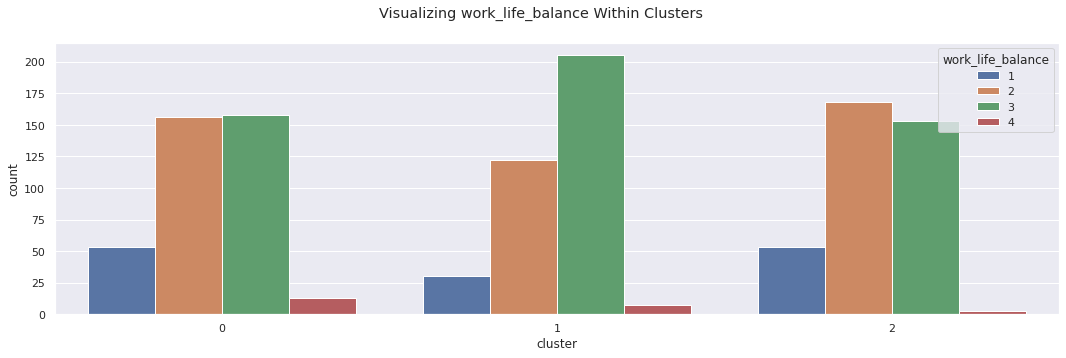

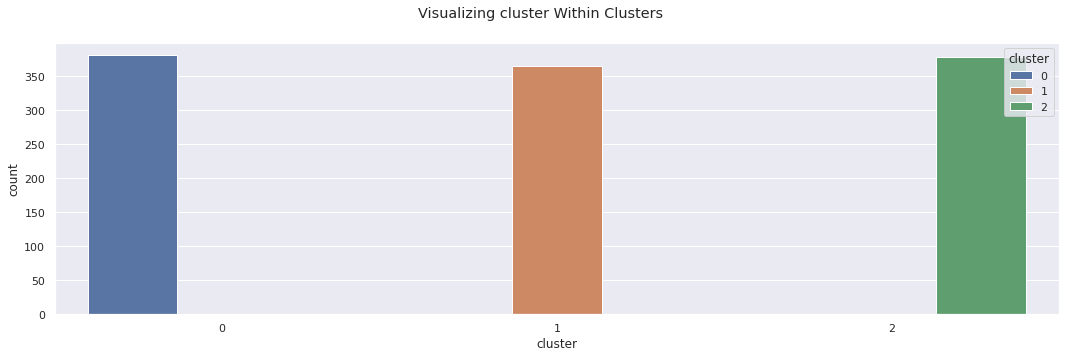

In [ ]:
sns.set_theme(style="darkgrid")

for col in predict_attrition:
  if col not in numeric + exploded_variables:
    fig, axs = plt.subplots(1, 1, figsize=(18,5))
    sns.countplot(x="cluster", hue=col,
        #palette=sns.color_palette("hls", num_palette),
        data=predict_attrition, ax=axs)
    fig.suptitle("Visualizing {} Within Clusters".format(col))
    fig.show()

#### Continuous Variables

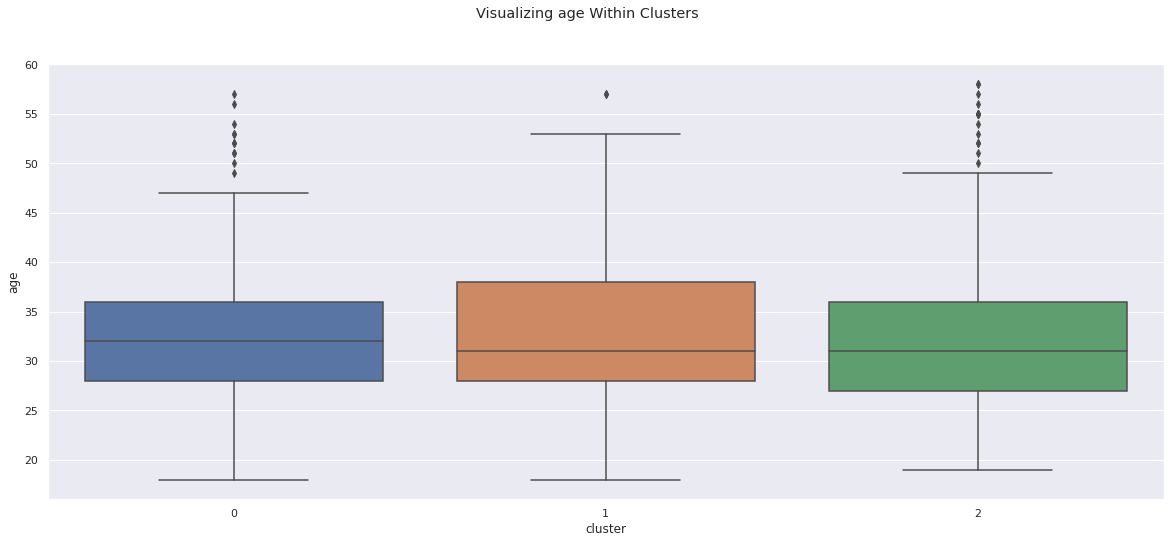

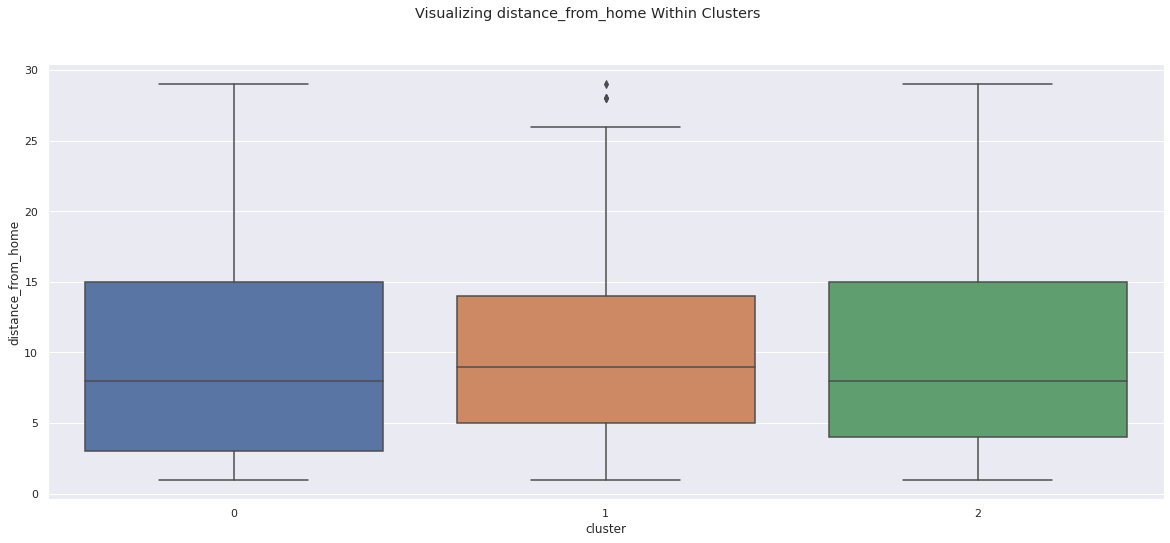

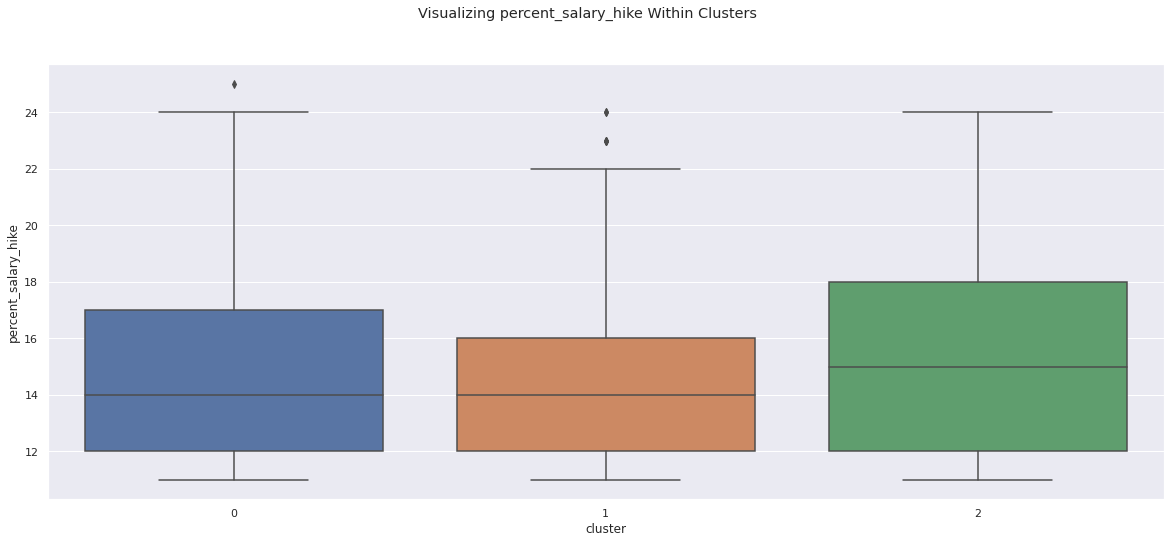

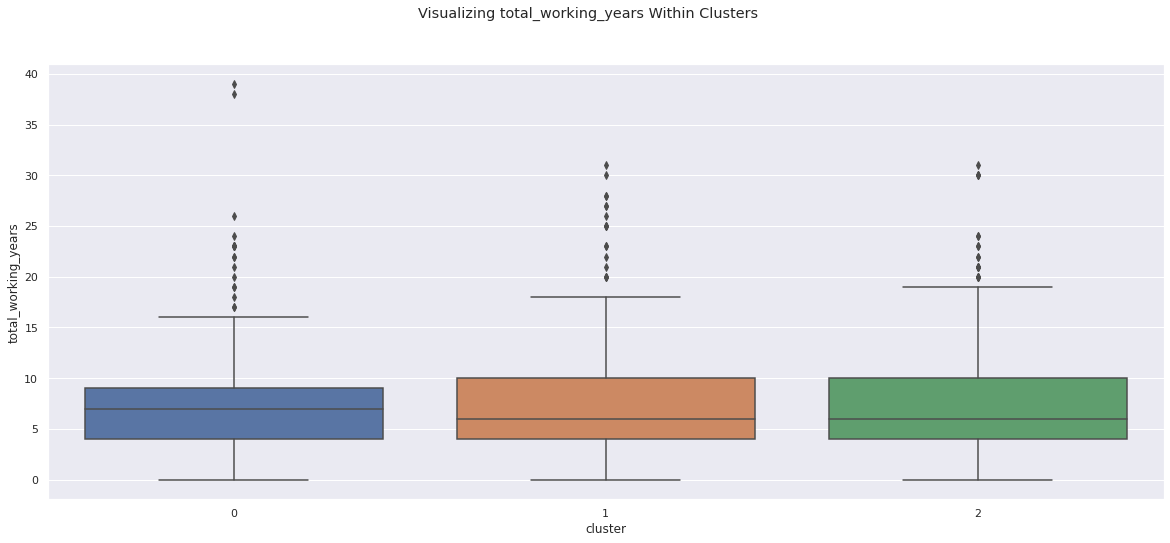

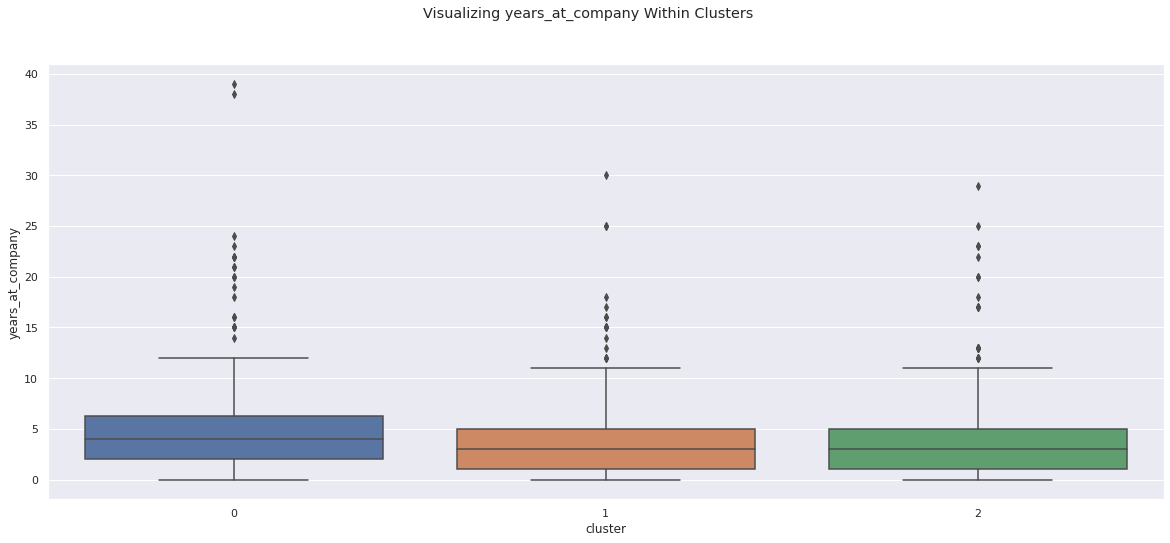

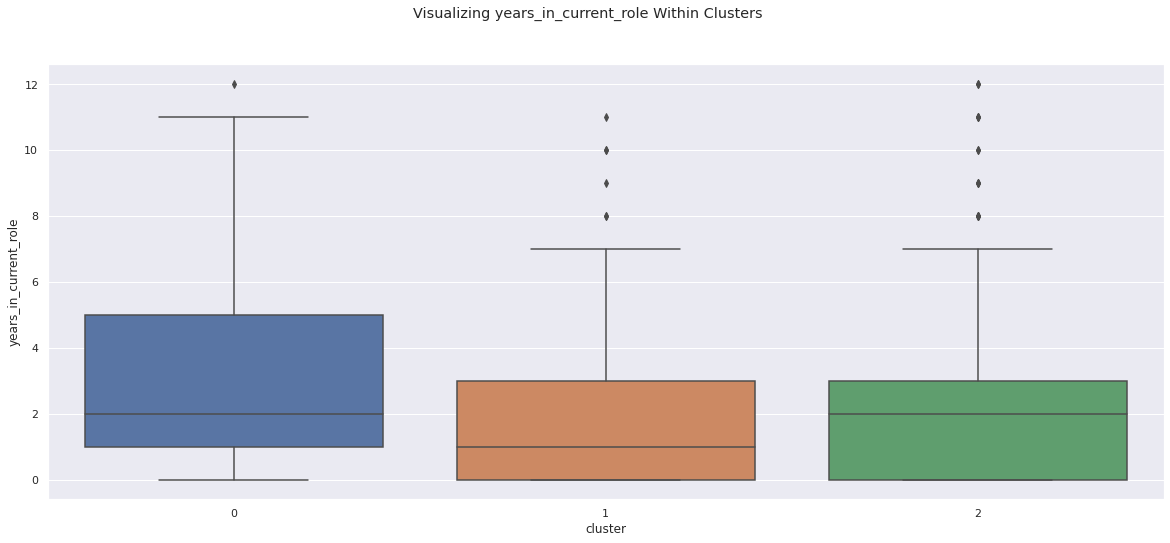

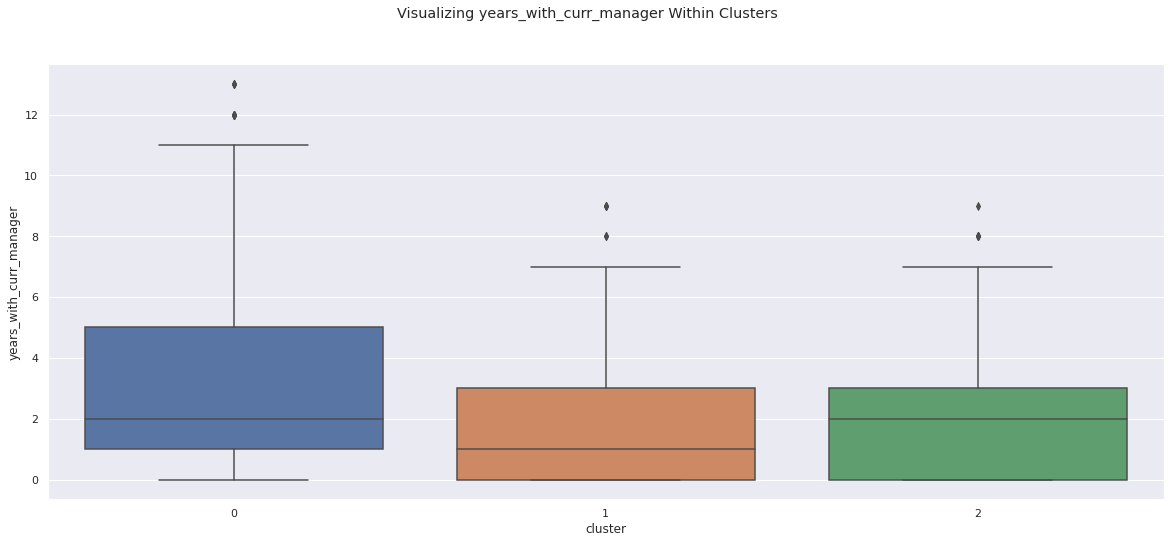

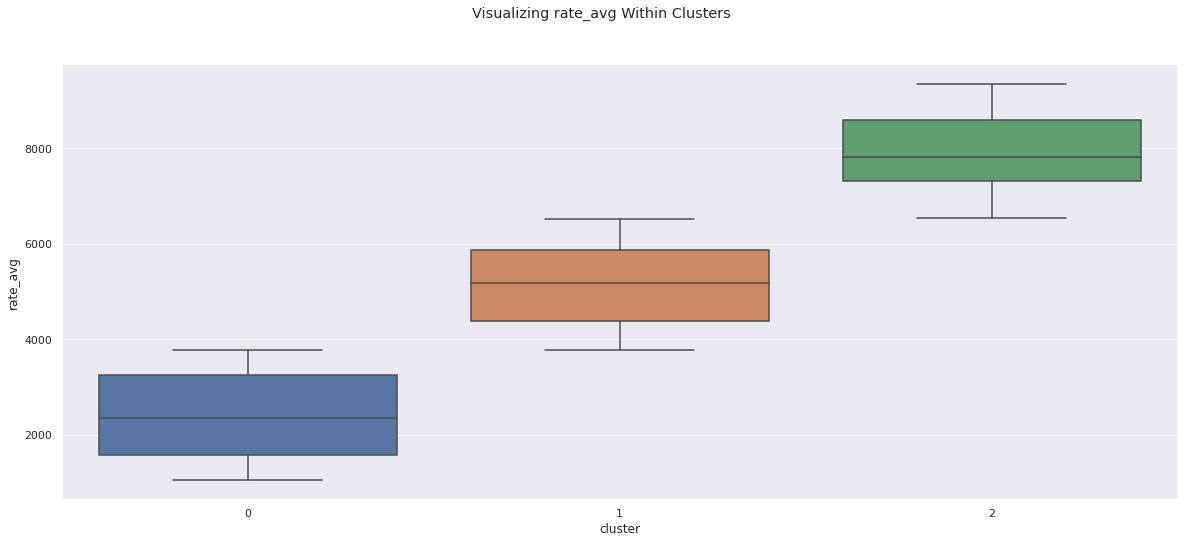

In [ ]:
continuous = ["rate_avg", "distance_from_home", "age", "years_in_current_role", "total_working_years", "years_at_company", "percent_salary_hike",
            "years_with_curr_manager"]
for col in predict_attrition:
  if col in continuous:
    fig, axs = plt.subplots(1, 1, figsize=(20,8))
    sns.boxplot(x="cluster", y=col,
        #palette=sns.color_palette("hls", num_palette),
        data=predict_attrition, ax=axs)
    fig.suptitle("Visualizing {} Within Clusters".format(col))
    fig.show()

In [ ]:
print(len(predict_attrition[predict_attrition["cluster"] == 0])/len(predict_attrition.index))
print(len(predict_attrition[predict_attrition["cluster"] == 1])/len(predict_attrition.index))
print(len(predict_attrition[predict_attrition["cluster"] == 2])/len(predict_attrition.index))

0.3389830508474576
0.3247100802854594
0.33630686886708294


#### Exploded Variables 

In [ ]:
# interpret the exploded variables 
iexdf = pd.DataFrame(predict_attrition[exploded_variables]).reset_index()
clusters = predict_attrition['cluster'].reset_index()
exdf = iexdf.merge(clusters, on = "index")
exdf = exdf.drop(['index'], axis = 1)

exdf= exdf.groupby(['cluster']).sum().transpose()


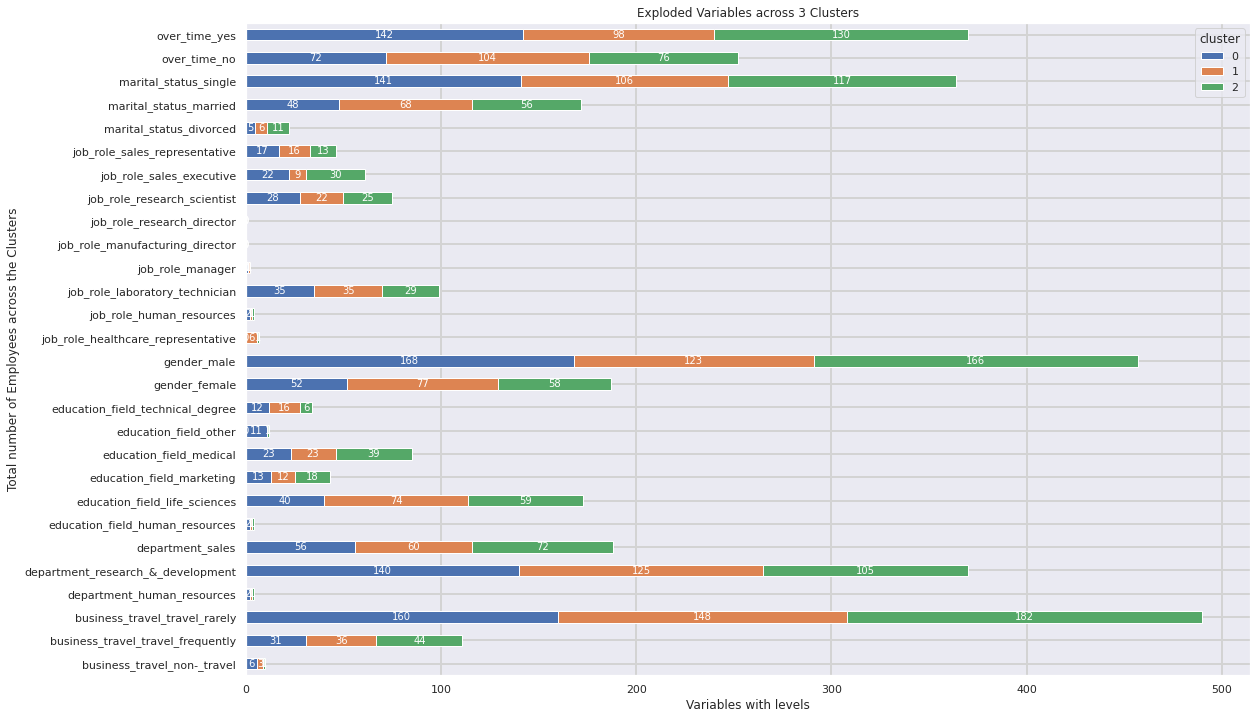

In [ ]:
rcParams['figure.figsize'] = 18,12

# create stacked bar chart
ax = exdf.plot(kind='barh', stacked=True)

# the reference code for the annotation can be found here: https://stackoverflow.com/questions/50160788/annotate-stacked-barplot-matplotlib-and-pandas 
for patch in ax.patches:
    w, h = patch.get_width(), patch.get_height()
    x, y = patch.get_xy() 
    ax.text(x+w/2, y+h/2, '{:.0f}'.format(w), 
            horizontalalignment='center', verticalalignment='center',
            color='white', fontsize=10)

# Add Title and Labels
plt.title('Exploded Variables across 3 Clusters')
plt.xlabel('Variables with levels')
plt.ylabel('Total number of Employees across the Clusters')
plt.grid(color='#D3D3D3', linestyle='-', linewidth=2)


### Cluster Descriptions

Cluster 0 (~35.7% of employees who left): Largely single, male employees with significantly lower pay than other clusters, with a wider distribution towards those who have been working the same roles with the same managers for many years. These employees leave with lower job involvement, having also done the most overtime work, but with low pay. They are also, in general, the least satisfied with their working environment out of other clusters, despite having an average level of job involvement. These employees are largely in R&D, with very few having education in life sciences compared to others. Out of all other clusters, these employees also have the lowest job level with poor satisfaction. Like those in the other clusters, these employees have very poor stock option levels. Overall, these employees can be classified as ones who work the most, but get paid the least.

Cluster 1 (~32.5% of employees who left): Employees in this cluster have the highest pay rates of all other clusters, and the lowest number of years in their current roles. They have the highest level of envionmental satisfaction and job involvement amongst all clusters. They are also quite satisfied with their jobs, where most are happy with their jobs despite leaving their roles. However, they have a slightly below average level of work-life balance. There are more females than the other clusters, and more tend to be married.

Cluster 2 (~31.8% of employees who left): These employees' rate average are in the middle of the pack, with average pay. Of all the clusters, they switch roles the most, with the lowest number of years in their current roles and with their current managers. They also rank around the middle with average environmental satisfaction. Like cluster 0, they have middle to low job involvement. These employees are also dissatisfied with their jobs and largely work in low job levels. These employees, however, score surprisingly high in work-life balance. These employees also rarely work overtime compared to others.